# Dog Breed Classifier Network Using Tensorflow

This is a demonstration of my learnings in artificial intelligence specifically deep learning. Following on from my project about building a supervised deep learning model from scratch, I now have further insight into the processes of a machine learning system whereby I belive it is fitting to now move on to a more efficient and conventient library for training models.

This model will be used to differentiate and classify 120 different breeds of dogs using a dataset found from http://vision.stanford.edu/aditya86/ImageNetDogs/ which has about 20,000 images. The breeds classified are:

|                                |                          |                             |                    |                             |                           |                             |
| ------------------------------ | ------------------------ | --------------------------- | ------------------ | --------------------------- | ------------------------- | --------------------------- |
| Afghan_hound                   | Bouvier_des_Flandres     | Eskimo_dog                  | Irish_wolfhound    | Norwegian_elkhound          | Scottish_deerhound        | West_Highland_white_terrier |
| African_hunting_dog            | Brabancon_griffon        | French_bulldog              | Italian_greyhound  | Norwich_terrier             | Sealyham_terrier          | Yorkshire_terrier           |
| Airedale                       | Brittany_spaniel         | German_shepherd             | Japanese_spaniel   | Old_English_sheepdog        | Shetland_sheepdog         | affenpinscher               |
| American_Staffordshire_terrier | Cardigan                 | German_short-haired_pointer | Kerry_blue_terrier | Pekinese                    | Shih-Tzu                  | basenji                     |
| Appenzeller                    | Chesapeake_Bay_retriever | Gordon_setter               | Labrador_retriever | Pembroke                    | Siberian_husky            | basset                      |
| Australian_terrier             | Chihuahua                | Great_Dane                  | Lakeland_terrier   | Pomeranian                  | Staffordshire_bullterrier | beagle                      |
| Bedlington_terrier             | Dandie_Dinmont           | Great_Pyrenees              | Leonberg           | Rhodesian_ridgeback         | Sussex_spaniel            | black-and-tan_coonhound     |
| Bernese_mountain_dog           | Doberman                 | Greater_Swiss_Mountain_dog  | Lhasa              | Rottweiler                  | Tibetan_mastiff           | bloodhound                  |
| Blenheim_spaniel               | English_foxhound         | Ibizan_hound                | Maltese_dog        | Saint_Bernard               | Tibetan_terrier           | bluetick                    |
| Border_collie                  | English_setter           | Irish_setter                | Mexican_hairless   | Saluki                      | Walker_hound              | borzoi                      |
| Border_terrier                 | English_springer         | Irish_terrier               | Newfoundland       | Samoyed                     | Weimaraner                | boxer                       |
| Boston_bull                    | EntleBucher              | Irish_water_spaniel         | Norfolk_terrier    | Scotch_terrier              | Welsh_springer_spaniel    | briard                      |
| pug                            | redbone                  | schipperke                  | silky_terrier      | soft-coated_wheaten_terrier | miniature_schnauzer       | standard_poodle             |
| toy_poodle                     | toy_terrier              | vizsla                      | whippet            | wire-haired_fox_terrier     | chow                      | groenendael                 |
| kelpie                         | komondor                 | kuvasz                      | malamute           | malinois                    | dingo                     | keeshond                    |
| papillon                       | pinscher                 | poodle                      | bull_mastiff       | cairn                       | clumber                   | otterhound                  |
| cocker_spaniel                 | collie                   | curly-coated_retriever      | golden_retriever   | dhole                       | flat-coated_retriever     | standard_schnauzer          |
| giant_schnauzer                |                          |                             |                    |                             |                           |                             |

# Initial imports and initializations

In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import datetime

In [2]:
%load_ext tensorboard

In [3]:
if not tf.test.gpu_device_name():
    print("no GPU found.")
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

tf.config.list_physical_devices('GPU') # this is the newer way

Default GPU Device: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preparing the image dataset

The Images are all of different sizes as they appear to have been webscraped from the internet. Tensorflow has some inbuilt image manipulation 'layers' which resize normalise the images to prepare them for training. This is incorporated into the model  

The images are also loaded into a tensorflow dataset object. This makes training easier because the image_dataset_from_directory function easily references and labels each image for the full dataset. Batches can also be defined to prevent exceeding memory limitations.

In [4]:
BATCH_SIZE = 100

In [5]:
prepare_image = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=False), #The images are resized to 224 x 224 pixels as corresponding to the training input size parameters
    tf.keras.layers.Rescaling(scale=1./255) # The rgb pixel data from each image is scaled to between 0 and 1
])

In [6]:
image_ds = tf.keras.utils.image_dataset_from_directory("./imagedataset/120breeds_dataset/", shuffle=True, labels='inferred', batch_size=BATCH_SIZE)

train_split = 0.8                          # The dataset is separated into testing and training data by an 80:20 split
training_size = np.ceil(len(image_ds)*0.8)

train_ds = image_ds.take(training_size) # Training dataset for the model to learn to differentiate
test_ds = image_ds.skip(training_size) # Testing dataset for unseen images to test the accuracy of the model

Found 20339 files belonging to 120 classes.


# Training the model

This model will be trained using a method called Transfer Learning. Transfer Learning is where I use a preexisting model and either add to or modify it for training to solve the problem. This learning approach is optimal for the tools and constraints for this project which is low computing resources (Home Computer with old GPU - GTX 1060) and time constraints. 

I have gotten a model from TensorflowHub which is a database of pretrained AI models supplied by Google for transfer learning and other implementations. This specific model is a feature vector model which essentially analyses an image and extracts the vital features out of it. I have then added another layer connecting to this pretrained feature vector network which has 120 outputs corresponding to the 120 different dog breeds being classified. 

In [7]:
IMAGE_SIZE = (224, 224)
classifier = tf.keras.Sequential([
    prepare_image, # This is the image manipulation layer created earlier
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5", trainable=False, arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Dense(120, activation="softmax"), # Softmax activation function maps the outputs to probabilities so that
])                                                    # the highest probability output is the most likely classification

classifier.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [8]:
# Checkpoint saving callback to save the model after each epoch 
checkpoint_path = "./training_cp/checkpoint.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1) 

# Tensorboard callback to save data for analysis using Tensorboard API - https://www.tensorflow.org/tensorboard/get_started
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
fitdata = classifier.fit(train_ds, epochs=100, batch_size=BATCH_SIZE, callbacks=[cp_callback, tensorboard_callback], validation_data=test_ds, validation_batch_size=BATCH_SIZE)

Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 4.4604 - accuracy: 0.0746
Epoch 1: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 53s 292ms/step - loss: 4.4604 - accuracy: 0.0746 - val_loss: 3.6992 - val_accuracy: 0.1924
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 3.1618 - accuracy: 0.2971
Epoch 2: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 47s 286ms/step - loss: 3.1618 - accuracy: 0.2971 - val_loss: 2.7792 - val_accuracy: 0.3897
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 2.4184 - accuracy: 0.4673
Epoch 3: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 48s 288ms/step - loss: 2.4184 - accuracy: 0.4673 - val_loss: 2.2206 - val_accuracy: 0.5123
Epoch 4/100
164/164 [==============================] - ETA: 0s - loss: 1.9666 - accuracy: 0.5636
Epoch 4: saving model to ./training_cp\checkp

164/164 [==============================] - 49s 297ms/step - loss: 0.5894 - accuracy: 0.8649 - val_loss: 0.8218 - val_accuracy: 0.7730
Epoch 30/100
164/164 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.8664
Epoch 30: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 50s 300ms/step - loss: 0.5801 - accuracy: 0.8664 - val_loss: 0.8161 - val_accuracy: 0.7774
Epoch 31/100
164/164 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8685
Epoch 31: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 297ms/step - loss: 0.5680 - accuracy: 0.8685 - val_loss: 0.8177 - val_accuracy: 0.7735
Epoch 32/100
164/164 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.8723
Epoch 32: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 298ms/step - loss: 0.5565 - accuracy: 0.8723 - val_loss: 0.8022 - val_accuracy: 0.7758
Ep

Epoch 58/100
164/164 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.9250
Epoch 58: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 298ms/step - loss: 0.3845 - accuracy: 0.9250 - val_loss: 0.7083 - val_accuracy: 0.7944
Epoch 59/100
164/164 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.9265
Epoch 59: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 298ms/step - loss: 0.3787 - accuracy: 0.9265 - val_loss: 0.7060 - val_accuracy: 0.7994
Epoch 60/100
164/164 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.9272
Epoch 60: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 297ms/step - loss: 0.3755 - accuracy: 0.9272 - val_loss: 0.7080 - val_accuracy: 0.7913
Epoch 61/100
164/164 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.9281
Epoch 61: saving model to ./training_c

164/164 [==============================] - 49s 298ms/step - loss: 0.2883 - accuracy: 0.9535 - val_loss: 0.6714 - val_accuracy: 0.8020
Epoch 87/100
164/164 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9554
Epoch 87: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 50s 301ms/step - loss: 0.2854 - accuracy: 0.9554 - val_loss: 0.6703 - val_accuracy: 0.8048
Epoch 88/100
164/164 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9552
Epoch 88: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 297ms/step - loss: 0.2846 - accuracy: 0.9552 - val_loss: 0.6714 - val_accuracy: 0.8030
Epoch 89/100
164/164 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9559
Epoch 89: saving model to ./training_cp\checkpoint.ckpt
164/164 [==============================] - 49s 298ms/step - loss: 0.2793 - accuracy: 0.9559 - val_loss: 0.6668 - val_accuracy: 0.8025
Ep

In [22]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 12672), started 3:51:16 ago. (Use '!kill 12672' to kill it.)

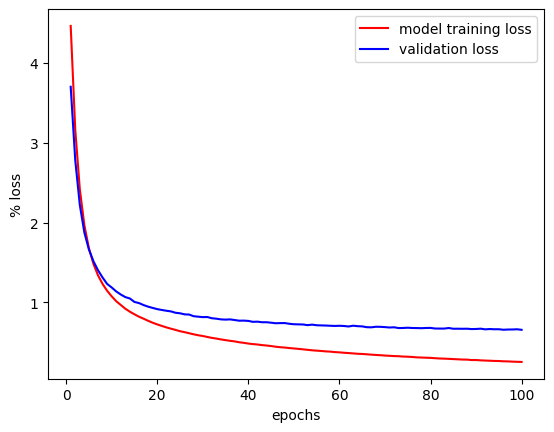

In [15]:
x_axis = [i + 1 for i in range(len(fitdata.history['loss']))]

plt.plot(x_axis, fitdata.history['loss'], 'r', label="model training loss")
plt.plot(x_axis, fitdata.history['val_loss'], 'b', label="validation loss")
plt.xlabel("epochs")
plt.ylabel("% loss")
plt.legend()
plt.show()

# Deploying the model

In [21]:
image = tf.keras.utils.load_img("./goldret.jpg")
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

image_ds.class_names[np.argmax(classifier.predict(input_arr))]

1/1 [==============================] - 0s 48ms/step


'golden_retriever'